In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [514]:
class NN(tf.keras.layers.Layer):
    
    def __init__(self, layers, lb, ub, **kwargs):
        """A dense Neural Net that is specified by layers argument.
        
           layers: input, dense layers and outputs dimensions  
           lb    : An array of minimums of inputs (lower bounds)
           ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)        
        self.lb = lb
        self.ub = ub
        
    def build(self, input_shape):         
        """Create the state of the layers (weights)"""
        weights = []
        biases = []        
        for l in range(0,self.num_layers-1):
            W = self.xavier_init(size=[self.layers[l], self.layers[l+1]])
            b = tf.Variable(tf.zeros([1,self.layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)
        
        self.Ws = weights
        self.bs = biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.compat.v1.truncated_normal([in_dim, out_dim], 
                                                         stddev=xavier_stddev, 
                                                         dtype=tf.float64), 
                           dtype=tf.float64)
    
    @tf.function
    def normalise_input(self, inputs):
        """Map the inputs to the range [-1, 1]"""
        return 2.0*(inputs - self.lb)/(self.ub - self.lb) - 1.0
    
    @tf.function
    def __net__(self, inputs):
        H = self.normalise_input(inputs)
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
            W = self.Ws[-1]
            b = self.bs[-1]
            outputs = tf.add(tf.matmul(H, W), b)
        return outputs
    
    def call(self, inputs, grads=True):
        """Defines the computation from inputs to outputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           grads:  Default 'True'. Returns the first and second 
                   order gradients of the output with respect to 
                   the input when the grads argument is 'True'.
                   
        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
                When 'grads=True', the list of first and second order gradients 
                of the output with respect to the input. 
                
        The returns 'partial_1' and 'partial_2' are the first and second 
        order gradients, repsectivly. Each one is a list that its elements
        corresponds to on of the NN's last layer output. e.g. if the last layer
        has Dn outputs, each list has Dn tensors as an elements. The dimensionality
        of the tensors are the same as inputs: [None, D1]
        
        """
        X = tf.cast(inputs, tf.float64)
        outputs = self.__net__(X)
        if grads:                        
            partials_1 = [tf.gradients(outputs[:,i], X)[0] for i in range(outputs.shape[1])]
            partials_2 = [tf.gradients(partials_1[i], X)[0] for i in range(outputs.shape[1])]
            return outputs, partials_1, partials_2            
        else:            
            return outputs   
    
    
class Loss():
    def __init__(self, pinn, name, data_size = 0, init_loss_weight = 1.0):
        """Loss value that is calulated for the output of the pinn
        
        Args:
            pinn: NN object that will be trained.
            name: The name of the Loss
            data_size: The length of its internal dataset.
            init_loss_weight: Initial weigth of the loss in comparision to others.
            
            
            When the Loss class has some internal data (e.g. inputs),
            it must provid the length of its data_size, since that value
            will be used to create randomly shuffled indices on btach training
            time.
        
        
        """
        self.pinn = pinn
        self.data_size = data_size
        self.name = name      
        self.init_loss_weight = init_loss_weight
    
    
    def batch(self, indices):
        """Returns a batch that will be proccessed in loss method
        
        Args:
           indices: Randomly shuffled indices for the current batch.
           
           Each loss class is responsible for its data. However, the 
           batch indices are provided by TINN class. So, this method
           slices the data that it will use in loss calculation (loss method)
           Note that whatever returns fromthis method will be the batch argument
           of the loss method, which is casted as Tensor by tensorflow.
           
           Example:
             return (self.input_1[indices], self.input_2[indices])
           
        """
        pass
    
    @tf.function
    def loss(self, batch):
        """A tensorflow function that calculates and returns the loss
        
        Args:
           batch: This is the value(s) that is returned from batch method.
                  Note that the values are converted to Tensors by Tensorflow
                  
           It must return the loss values
           
           Example:
              input_1, input_2 = batch
              ouput_1 = self.pinn(input_1)
              ouput_2 = self.pinn(input_2)
              L = tf.reduce_sum(tf.square(output_1 - output_1), name=self.name)
              return L
        
        """
        pass
    
    def loss_weight(self, iteration):
        """Return weigth of the loss in comparision to others
        
        Args: 
            iteration: the iteration index ( for hyper-parametrs that update
                       during the training)
        """
        return self.init_loss_weight
    
    def trainable_vars(self):
        """Retruns a list of Tensorflow variables for training
        
           If the loss class has some tarinable variables, it can
           return them as a list. These variables will be updated 
           by optimiser, if they are already part of the computation 
           graph.
        
        """
        return []
    
    def trainable_vars_str(self):  
        s = ""
        t_vars = self.trainable_vars()
        if len(t_vars) > 0:
            s +=  ", ".join([ f"{v.name}:{self.__get_val__(v):.8f}" for v in t_vars])
        return s
    
    def __get_val__(self, item):
        val = item.numpy()
        if type(val) is float:
            return val
        else:
            return val[0]
        
        
    
class Observations(Loss):
    def __init__(self, pinn, inputs_obs, outputs_obs):        
        self.inputs_obs = inputs_obs
        self.outputs_obs = outputs_obs
        super().__init__(pinn, "Loss_observations", inputs_obs.shape[0])
        
    def batch(self, indices):
        return (self.inputs_obs[indices], self.outputs_obs[indices])
    
    @tf.function
    def loss(self, batch):
        inputs, outputs = batch
        obs_pred = self.pinn(inputs, grads = False)
        L = tf.reduce_sum(tf.square(obs_pred - outputs), name = self.name)
        return L
    
class Periodic_boundary(Loss):
    def __init__(self, pinn, inputs_LB_boundary, inputs_TR_boundary):        
        self.inputs_LB_boundary = inputs_LB_boundary
        self.inputs_TR_boundary = inputs_TR_boundary
        super().__init__(pinn, "Loss_Periodic_Boundary", inputs_LB_boundary.shape[0])
    
    def batch(self, indices):
        return self.inputs_LB_boundary[indices], self.inputs_TR_boundary[indices]
    
    @tf.function
    def loss(self, batch):
        inputs_LB, inputs_TR = batch
        boundary_LB_pred = self.pinn(inputs_LB, grads = False)
        boundary_TR_pred = self.pinn(inputs_TR, grads = False)
        L = tf.reduce_sum(tf.square(boundary_LB_pred - boundary_TR_pred), 
                          name = self.name)
        return L
    
class Truing_PDE(Loss):
    def __init__(self, pinn, inputs_pde, name="Loss_Turing_PDE"):        
        self.inputs_pde = inputs_pde
        super().__init__(pinn, name ,inputs_pde.shape[0])
        
    def batch(self, indices):
        return self.inputs_pde[indices]
       
    @tf.function
    def loss(self, batch):
        inputs = batch
        pde_outputs, partials_1, partials_2 = self.pinn(inputs, grads = True)
        
        pde_res = self.pde(pde_outputs, partials_1, partials_2)
        L = tf.reduce_sum(tf.square(pde_res), name = self.name)
        return L
    
    def pde(self, outputs, partials_1, partials_2):
        pass
    
class ASDM(Truing_PDE):
    def __init__(self, pinn, inputs_pde):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM")
        self.sigma_a = tf.Variable([0.0], dtype=tf.float64,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([1.00], dtype=tf.float64, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([1.00], dtype=tf.float64, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([1.00], dtype=tf.float64,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def trainable_vars(self):
        return [self.sigma_a,
                self.sigma_s,
                self.mu_a,
                self.rho_a,
                self.rho_s,
                self.kappa_a]
        
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float64)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a,axis=1), 
                          tf.expand_dims(f_s,axis=1),], axis = 1)
    
class TINN():
    """Turing-Informed Neoral Net"""
    def __init__(self,
                 pinn,
                 losses: Loss):
        self.pinn = pinn
        self.losses = losses        
        self.optimizer_Adam = keras.optimizers.Adam()
        
        
    def __indices__(self, batch_size, *ns):
        """Generator of indices for specified sizes"""
        n1 = ns[0]
        ns_remain = ns[1:] if len(ns) > 1 else []                
        # First indices        
        batch_steps = n1//batch_size
        batch_steps = batch_steps + (n1-1)//(batch_steps*batch_size)
        # remaining indices        
        indices_batch_size = [n_i//batch_steps for n_i in ns_remain]         
        # indices
        indices = [np.array(list(range(n_i))) for n_i in ns]        
        for arr in indices:
            np.random.shuffle(arr)
            
        for batch in range(batch_steps):
            # Observation start-end
            n1_start = batch*batch_size
            n1_end = (batch+1)*batch_size
            n1_end = n1_end - (n1_end//n1)*(n1_end%n1)
            # remaining indices
            starts = [batch*size for size in indices_batch_size]
            ends = [(batch+1)*size for size in indices_batch_size]                                       
            # Correction for remining indices
            if batch == batch_steps-1:
                ends = [end if end < ns[i] else ns[i]  for i, end in enumerate(ns_remain)]
            # step's indices            
            yield [indices[0][n1_start:n1_end]] + \
                  [indices[i+1][star:end] for i, (star, end) in enumerate(zip(starts, ends))]
                   
    def train(self, epochs, batch_size, print_iter=10):
        
        datasets_sizes = [ item.data_size for item in self.losses] 
        samples_total_loss = np.zeros(epochs)
        samples_losses = np.zeros((epochs,len(self.losses)))
        
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0
            loss_vals = np.zeros(len(self.losses))

            for indices_list in self.__indices__(batch_size, *datasets_sizes):
                batches_list = [ l.batch(indices) for l, indices in zip(self.losses,indices_list)]                 
                batch_total_loss, batch_loss_vals = self.train_step(batches_list, epoch)
                total_loss += batch_total_loss
                loss_vals += [l.numpy() for l in batch_loss_vals]

                
            if epoch % print_iter == 0:
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")
                start_time = time.time()
                
            samples_total_loss[epoch] = total_loss
            samples_losses[epoch, : ] = loss_vals
            
        return (samples_total_loss, samples_losses)
    
    @tf.function
    def train_step(self, batches_list, iteration):        
            
        with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:            
            losses = []
            for l, batch in zip(self.losses, batches_list):
                L = l.loss(batch)*l.loss_weight(iteration)
                losses += [L]
                
            batch_loss = tf.reduce_sum(losses, name="Total_batch_loss")
            
        #grads = tape.gradient(batch_loss,  self.trainable_vars)
        grads = tape.gradient(batch_loss,  tape.watched_variables())
        #self.optimizer_Adam.apply_gradients(zip(grads, self.trainable_vars))
        self.optimizer_Adam.apply_gradients(zip(grads, tape.watched_variables()))
        
        return batch_loss, losses


In [515]:
def lower_upper_bounds(inputs_of_inputs):
    """Find the lower and upper bounds of inputs
    
       inputs_of_inputs: a list of tensors that their axis one have the same number 
                         of columns
    """
           
    inputs_dim = np.asarray(inputs_of_inputs[0]).shape[1]
    lb = np.array([np.inf] * inputs_dim)
    ub = np.array([-np.inf] * inputs_dim)
    for i, inputs in enumerate(inputs_of_inputs):        
        assert inputs_dim == np.asarray(inputs).shape[1]
        lb = np.amin(np.c_[inputs.min(0), lb], 1)
        ub = np.amax(np.c_[inputs.max(0), ub], 1)
        
    return lb, ub
    
def normalise_inputs(inputs_of_inputs):
    """Scales the values along axis 1 to [-1, 1]
    
       inputs_of_inputs: a list of tensors that their axis one have the same number 
                         of columns
    """
    if type(inputs_of_inputs) is not list:
        inputs_of_inputs = [inputs_of_inputs]        
            
    lb, ub = lower_upper_bounds(inputs_of_inputs)
    return [2.0*(inputs-lb)/(ub-lb) - 1.0 for inputs in inputs_of_inputs]    

In [516]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_TR = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_TR = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_TR = np.tile(boundary_x_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_TR = np.tile(boundary_y_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_TR': np.c_[boundary_XX_TR[idx_boundary],
                                       boundary_YY_TR[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [517]:
model_params_1 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])

In [523]:
pinn = NN(layers, lb, ub)
losses = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
         ASDM(pinn,
              inputs_pde = dataset['pde']),
         Periodic_boundary(pinn,
                          inputs_LB_boundary = dataset['boundary_LB'], 
                          inputs_TR_boundary = dataset['boundary_TR'])]

In [524]:
model = TINN(pinn, losses)

In [525]:
arr_total_loss, arr_losses = model.train(10000,batch_size=dataset['obs_input'].shape[0]//8, print_iter=200)

Epoch: 0, loss:35366.68
Loss_observations:20916.99372356 
Loss_ASDM:14315.33350189 sigma_a:0:0.00603408, sigma_s:0:0.99212040, mu_a:0:0.99302148, rho_a:0:1.00040734, rho_s:0:1.00658745, kappa_a:0:0.99774838
Loss_Periodic_Boundary:134.35105874 
Time:7.91

Epoch: 200, loss:2154.15
Loss_observations:2148.29761518 
Loss_ASDM:3.13478911 sigma_a:0:0.09563690, sigma_s:0:0.87381018, mu_a:0:0.88763274, rho_a:0:1.10939141, rho_s:0:1.22832552, kappa_a:0:0.78303254
Loss_Periodic_Boundary:2.72096386 
Time:49.33

Epoch: 400, loss:2153.44
Loss_observations:2147.57618775 
Loss_ASDM:2.85946714 sigma_a:0:0.09705297, sigma_s:0:0.86839066, mu_a:0:0.88323627, rho_a:0:1.10658371, rho_s:0:1.22672553, kappa_a:0:0.79145755
Loss_Periodic_Boundary:3.00134198 
Time:49.25

Epoch: 600, loss:2152.08
Loss_observations:2147.87941326 
Loss_ASDM:2.22758473 sigma_a:0:0.10014777, sigma_s:0:0.85579315, mu_a:0:0.87587571, rho_a:0:1.09978354, rho_s:0:1.22232146, kappa_a:0:0.80907126
Loss_Periodic_Boundary:1.97274080 
Time:49

Epoch: 6600, loss:209.17
Loss_observations:118.57374295 
Loss_ASDM:82.33954680 sigma_a:0:0.08059113, sigma_s:0:0.06089887, mu_a:0:1.58343312, rho_a:0:1.37485510, rho_s:0:0.05551209, kappa_a:0:0.17264844
Loss_Periodic_Boundary:8.25979331 
Time:50.60

Epoch: 6800, loss:217.60
Loss_observations:120.26421312 
Loss_ASDM:84.91817401 sigma_a:0:0.08722540, sigma_s:0:0.06108271, mu_a:0:1.61744252, rho_a:0:1.39792615, rho_s:0:0.05524146, kappa_a:0:0.17264012
Loss_Periodic_Boundary:12.42253154 
Time:50.26

Epoch: 7000, loss:205.32
Loss_observations:112.39236218 
Loss_ASDM:81.53608923 sigma_a:0:0.09420186, sigma_s:0:0.06168265, mu_a:0:1.65046280, rho_a:0:1.42142678, rho_s:0:0.05503300, kappa_a:0:0.17218752
Loss_Periodic_Boundary:11.39639236 
Time:49.62

Epoch: 7200, loss:203.64
Loss_observations:107.85555878 
Loss_ASDM:80.56930813 sigma_a:0:0.10061383, sigma_s:0:0.06158544, mu_a:0:1.68177081, rho_a:0:1.44475128, rho_s:0:0.05527783, kappa_a:0:0.17241134
Loss_Periodic_Boundary:15.21767334 
Time:50.1

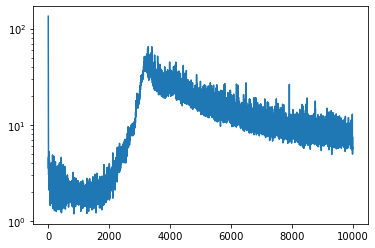

In [530]:
plt.plot(arr_losses[:,2])
plt.yscale('log')
plt.show()

In [ ]:
arr_total_loss2, arr_losses2 = model.train(10000,batch_size=dataset['obs_input'].shape[0]//8, print_iter=200)

Epoch: 0, loss:155.22
Loss_observations:83.18583532 
Loss_ASDM:65.03639502 sigma_a:0:0.17624217, sigma_s:0:0.06170394, mu_a:0:2.06095097, rho_a:0:1.73926466, rho_s:0:0.05667740, kappa_a:0:0.18143927
Loss_Periodic_Boundary:6.99720099 
Time:0.28

Epoch: 200, loss:151.77
Loss_observations:80.39914812 
Loss_ASDM:63.40993794 sigma_a:0:0.18136186, sigma_s:0:0.06272572, mu_a:0:2.08378976, rho_a:0:1.75856722, rho_s:0:0.05564608, kappa_a:0:0.18190478
Loss_Periodic_Boundary:7.96396697 
Time:51.12

Epoch: 400, loss:148.21
Loss_observations:80.45783066 
Loss_ASDM:60.73595033 sigma_a:0:0.18556268, sigma_s:0:0.06147172, mu_a:0:2.10647888, rho_a:0:1.77705076, rho_s:0:0.05696130, kappa_a:0:0.18250082
Loss_Periodic_Boundary:7.01287360 
Time:50.19

Epoch: 600, loss:146.81
Loss_observations:78.56147738 
Loss_ASDM:60.81958897 sigma_a:0:0.19008030, sigma_s:0:0.06168259, mu_a:0:2.12968006, rho_a:0:1.79549527, rho_s:0:0.05671472, kappa_a:0:0.18345644
Loss_Periodic_Boundary:7.43093504 
Time:49.81

Epoch: 800,

In [252]:
layers = [3, 10, 10, 10, 2]
sample_xyt  = np.array([ [0, 0, 0],
                         [0, 1, 0],
                         [1, 0, 0],
                         [1, 1, 0],
                         [0, 0, 1],
                         [0, 1, 1],
                         [1, 0, 1],
                         [1, 1, 1],
                         [0, 0, 2],
                         [0, 1, 2],
                         [1, 0, 2],
                         [1, 1, 2]
                       ])

lb, ub = lower_upper_bounds([sample_xyt])
#print(normalise_inputs([sample_xyt, sample_xyt.copy()*2]))

model = NN(layers, lb, ub)

In [255]:
#from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()
i = tf.constant(sample_xyt*1.0)
#o, p1, p2 = model(i, True)
o = model(i, False)

In [259]:
model.trainable_weights == model.trainable_variables

True

In [114]:
dataset.keys()

dict_keys(['obs_input', 'obs_output', 'pde', 'boundary_LB', 'boundary_TR'])

In [108]:
T*16

8192

In [115]:
dataset['boundary_LB'].shape

(4096, 3)

In [69]:
asdm = ASDM(layers, 
           inputs_obs = np.c_[dataset['x_obs'], dataset['y_obs'], dataset['t_obs']],
           output_obs = np.c_[dataset['a_obs'], dataset['s_obs']]
            )

In [70]:
asdm.train(400, T*4, print_iter=100)

Epoch: 0, loss:35680.41, 
Time:1.70

Epoch: 100, loss:2178.56, 
Time:6.64

Epoch: 200, loss:2176.05, 
Time:6.57

Epoch: 300, loss:2176.39, 
Time:6.57



In [71]:
asdm.model_vars()

[<tf.Variable 'sigma_a:0' shape=(1,) dtype=float64, numpy=array([0.10185468])>,
 <tf.Variable 'sigma_s:0' shape=(1,) dtype=float64, numpy=array([0.83944022])>,
 <tf.Variable 'mu_a:0' shape=(1,) dtype=float64, numpy=array([0.88263012])>,
 <tf.Variable 'rho_a:0' shape=(1,) dtype=float64, numpy=array([1.12305397])>,
 <tf.Variable 'rho_s:0' shape=(1,) dtype=float64, numpy=array([1.19049248])>,
 <tf.Variable 'kappa_a:0' shape=(1,) dtype=float64, numpy=array([0.82351467])>]

In [ ]:
class TINN2():
    """Turing-Informed Neoral Net"""
    def __init__(self, 
                 layers, 
                 inputs_obs,
                 output_obs,
                 inputs_pde = None,
                 boundary_spec = dict(
                    inputs_boundary = None,
                    boundary_loss_callback = None,
                    needs_grad = False 
                   )                 
                 ):
        self.model = NN(layers)
        self.inputs_obs = inputs_obs
        self.output_obs = output_obs        
        # Use the observation points for validating
        # PDE
        if inputs_pde is None:
            self.inputs_pde = inputs_obs
        else:
            self.inputs_pde = inputs_pde
            
        self.boundary_spec = boundary_spec
        if boundary_spec['inputs_boundary'] is None:
            self.has_bounday = False
        else:
            self.has_bounday = True
        if self.boundary_spec['boundary_loss_callback'] is None:
            self.boundary_loss_callback = self.periodic_boundary
        else:
            self.boundary_loss_callback = self.boundary_spec['boundary_loss_callback']        
        
        self.optimizer_Adam = keras.optimizers.Adam()
        #self.optimizer_Adam = tf.train.AdamOptimizer()
        #self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
     
    def periodic_boundary(self, inputs, boundary_pred, boundary_spec):        
        pass
    
    def pde_residuals(self, pde_inputs, pde_outputs, partials_1, partials_2):
        pass
    
    def model_vars(self):
        return []
    
    def loss_obs(self, inputs, outputs):
        obs_pred = self.model(inputs, grads = False)
        L = tf.reduce_sum(tf.square(obs_pred - outputs), name = "Loss_observations")
        return L
    
    def loss_pde(self, inputs):
        pde_outputs, partials_1, partials_2 = self.model(inputs, grads = True)
        pde_res = self.pde_residuals(inputs, pde_outputs, partials_1, partials_2)
        L = tf.reduce_sum(tf.square(pde_res), name = "Loss_pde")
        return L
        
    def loss_boundary(self, inputs, outputs):
        boundary_pred = self.model(inputs, self.boundary_spec['needs_grad'])        
        L = self.boundary_loss_callback(inputs, boundary_pred, self.boundary_spec)        
        return L
        
    
        
    def __batches__(self, batch_size):
        """Generator that returned shuffled indeces for each batch"""
        
        flg_boundary = self.has_bounday
        # Observation batch info 
        obs_n = self.inputs_obs.shape[0]
        batch_steps = obs_n//batch_size
        batch_steps = batch_steps + (obs_n-1)//(batch_steps*batch_size)
        # PDE batch info
        pde_n = self.inputs_pde.shape[0]
        pde_batch_size = pde_n//batch_steps        
        # Boundary condition batch info
        if flg_boundary:
            boundary_n = self.boundary_spec.inputs_boundary.shape[0]        
            boundary_batch_size = boundary_n//batch_steps
        # Observation indices   
        indices_obs = np.array(list(range(obs_n)))
        np.random.shuffle(indices_obs)
        # PDE  indices
        indices_pde = np.array(list(range(pde_n)))        
        np.random.shuffle(indices_pde)
        # Boundary condition  indices
        if flg_boundary:
            indices_boundary = np.array(list(range(boundary_n)))
            np.random.shuffle(indices_boundary)
            
        for batch in range(batch_steps):
            # Observation start-end
            obs_start = batch*batch_size
            obs_end = (batch+1)*batch_size
            obs_end = obs_end - (obs_end//obs_n)*(obs_end%obs_n)
            # PDE  start-end
            pde_start = batch*pde_batch_size
            pde_end = (batch+1)*pde_batch_size            
            # Boundary condition  start-end
            if flg_boundary:
                boundary_start = batch*boundary_batch_size
                boundary_end = (batch+1)*boundary_batch_size
                
            # Correction for PDE and boundary batches at last step
            if batch == batch_steps-1:
                if pde_end < pde_n:
                    pde_end = pde_n
                        
                if flg_boundary and boundary_end < boundary_n:
                    boundary_end = boundary_n
            # step's indices        
            batch_indices_obs = indices_obs[obs_start:obs_end]
            batch_indices_pde = indices_pde[pde_start:pde_end]
            if flg_boundary:
                batch_indices_boundary = indices_boundary[boundary_start:boundary_end]
                yield (batch_indices_obs, batch_indices_pde, batch_indices_boundary)
            else:
                yield (batch_indices_obs, batch_indices_pde, None)
        
    def train(self, epochs, batch_size, print_iter=10):
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0            
            for obs_indeces, pde_indeces, boundary_indices in self.__batches__(batch_size):                
                obs_inputs_batch  = self.inputs_obs[obs_indeces]
                obs_outputs_batch = self.output_obs[obs_indeces]
                pde_inputs_batch  = self.inputs_pde[pde_indeces] 
                if self.has_bounday:
                    boundary_inputs_batch = self.boundary_spec.inputs_boundary[boundary_indices]
                    L = self.train_step(obs_inputs_batch, 
                                        obs_outputs_batch, 
                                        pde_inputs_batch,
                                        boundary_inputs_batch)
                else:
                    L = self.train_step(obs_inputs_batch, 
                                        obs_outputs_batch, 
                                        pde_inputs_batch,
                                        None)
                total_loss += L
                
            if epoch % print_iter == 0:
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch}, loss:{total_loss:.2f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
    
    @tf.function
    def train_step(self, 
                   obs_inputs_batch, 
                   obs_outputs_batch, 
                   pde_inputs_batch,
                   boundary_inputs_batch):
        
        with tf.GradientTape() as tape:
            loss_obs = self.loss_obs(obs_inputs_batch, obs_outputs_batch)
            loss_pde = self.loss_pde(pde_inputs_batch)
                    
            loss = loss_obs + loss_pde
            if self.has_bounday:
                loss += self.loss_boundary(boundary_inputs_batch)
                
        
        trainable_vars = self.model.trainable_weights + self.model_vars()
        grads = tape.gradient(loss,  trainable_vars)
        self.optimizer_Adam.apply_gradients(zip(grads, trainable_vars))        
        return loss
        

class ASDM2(TINN):
    def __init__(self,
                 *arg,
                 **kwargs):
        super().__init__(*arg, **kwargs)
        
        
        self.sigma_a = tf.Variable([0.0], dtype=tf.float64,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([1.00], dtype=tf.float64, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([1.00], dtype=tf.float64, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([1.00], dtype=tf.float64, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([1.00], dtype=tf.float64,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def model_vars(self):
        return [self.sigma_a,
                self.sigma_s,
                self.mu_a,
                self.rho_a,
                self.rho_s,
                self.kappa_a
               ]
    
    def pde_residuals(self, pde_inputs, pde_outputs, partials_1, partials_2):    
        
        a = pde_outputs[:, 0]
        s = pde_outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float64)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a,axis=1), 
                          tf.expand_dims(f_s,axis=1),], axis = 1)